# Lab Assignment: Disease Classification

In this exercise, you will learn to use the structure inherent in gene expression data to help classify samples by disease status. The following exercise is based on the results of Best et al. __2015__, "RNA-Seq of Tumor-Educated Platelets Enables Blood-Based Pan-Cancer, Multiclass, and Molecular Pathway Cancer Diagnostics", _Cancer Cell_, 28, Pgs. 666–676. In summary, the paper uses quantifications of the mRNA content of blood platelets using RNA-seq experiments, in order to determine whether some blood-based biomarkers can be obtained for 6 different cancer types. The concept is based on the idea that platelets can be "educated" by tumors, either by direct incorporation of tumor-derived biomolecules, or through specific splicing events induced by tumor-driven signaling. These signatures of tumor-educated platelets (TEP) can be evaluated through analysis of the transcript expression patterns in different individuals.

The lab assignment aims to explore pre-processing and possible technical biases of the data, followed by unsupervised clustering methods, supervised machine learning models, and finally, the quality of these models. 

## Preprocessing and unsupervised clustering of the data

### Import the necessary libraries

In [0]:
import pandas as pd
from sklearn import preprocessing,decomposition
import plotnine as p9
from sklearn import cluster
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [0]:
#google drive connection
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Normalization of the data

In this step, you will normalize the data by the transformation \begin{equation*} x_{i} \to \frac{x_{i} - \mu}{\sigma}, \end{equation*} where $\mu$ is the mean and $\sigma$ is the standard deviation of the data. This is done to ensure that the scales of all the expression values are about the same, and thus prevents biases in the weight attached to a given variable, simply because its magnitude happens to be larger or smaller on average. These shifted and rescaled values are the so-called Z-scores of the data.

In [0]:
#### In the space below, you will 
### 1. Use the read.csv command from pandas to read the gene expression matrix from the file 
#### "TEP_RNAseq_geneRPKM_filtered.tsv"

#link from mounted drive file
gene_expr = pd.read_csv(
    "/content/gdrive/My Drive/[YCMI_CBDS Summer Course] Data/bioinformatics/TEP_RNAseq_geneRPKM_filtered.txt",
                        sep="\t",
                        header=None)

#### 2. Create an object of the class "StandardScaler" available in the "preprocessing" library
scaler_obj = preprocessing.StandardScaler()

#### 3. "fit" the gene expression matrix, i.e. use the function "fit" to find the mean and standard deviation
scaler_obj.fit(gene_expr)

#### 4. Use these fit values to "transform" the matrix
gene_expr_norm = scaler_obj.transform(gene_expr)


### Principal Component Analyis (PCA) of the data

Now, you will perform a PCA on the data to visualize any possible structure. You will plot the projections of the data points onto pairs of principal components of the data, and color the data points by the diagnosis and by the sequencing batch. This step is mainly to serve as a check on any systematic biases associated with the data due to technical variation. It also allows you to quickly check on how separable the data is, and thus how likely any classification methods are likely to be.

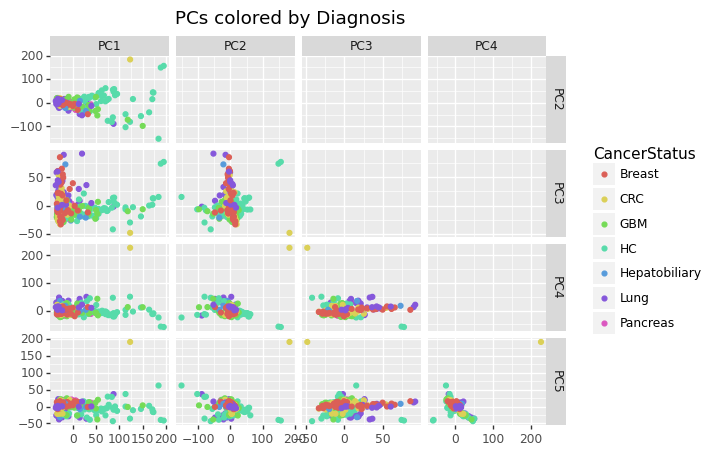

<ggplot: (8764509992417)>

In [0]:
#### Create a PCA object with 5 components (an object with no data at first)

n_components = 5

pca = decomposition.PCA(n_components=n_components)

#### Now use "fit_transform" to run a PCA on the normalized gene expression data and project it onto the first
#### 5 components; this is the reduced description
gene_reduced = pca.fit_transform(gene_expr_norm)

# create a list of PCA labels (pca column dimensions)
pca_labels = []
for i in range(n_components):
  # start label at PC1 rather than PC0
  pca_labels.append(f"""PC{i + 1}""")

#lazy load
gene_reduced_df = pd.DataFrame(gene_reduced, columns=pca_labels)

#read in SampleIDs_RPKM
ids = pd.read_csv("/content/gdrive/My Drive/[YCMI_CBDS Summer Course] Data/bioinformatics/SampleIDs_RPKM_filtered.txt",
                  sep="\t").reset_index()

#plot the data, facet y=PCY, x=PCX
plot_data = []
for pcx in pca_labels:
  for pcy in pca_labels:
    if pcx < pcy:
      plot_data.append(pd.DataFrame(
          {
              'CancerStatus': ids['CancerStatus'],
              'Batch': ids['Batch'],
              'PCX': pcx, 
              'PCY': pcy, 
              'X': gene_reduced_df[pcx],
              'Y': gene_reduced_df[pcy]
          }
      ))

(
    p9.ggplot(pd.concat(plot_data))
      + p9.geom_point(p9.aes(x="X", y="Y", color="CancerStatus"))
      + p9.facet_grid("PCY~PCX",scales="free")
      + p9.labs(x="", y="")
      + p9.labels.ggtitle("PCs colored by Diagnosis")
)

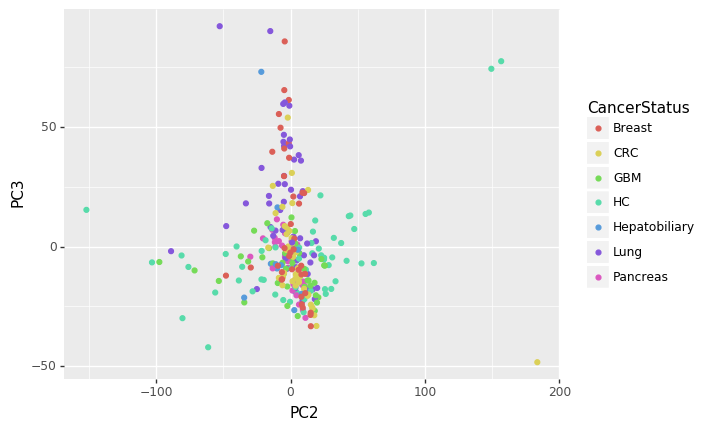

<ggplot: (-9223363277338393400)>

In [0]:
#we can visualize a single dimension as well
(
    p9.ggplot(pd.DataFrame({
      'CancerStatus': ids['CancerStatus'],
      'Batch': ids['Batch'],
      'X': gene_reduced_df['PC2'],
      'Y': gene_reduced_df['PC3']
    }))
    + p9.geom_point(p9.aes(x="X", y="Y", color="CancerStatus"))
    + p9.labs(x="PC2", y="PC3")
)

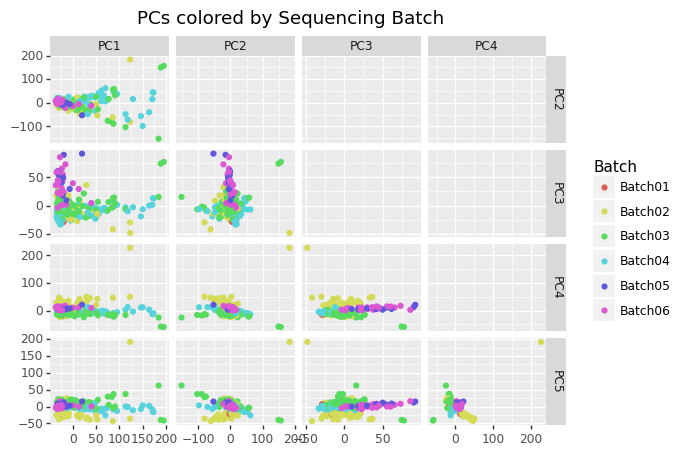

<ggplot: (-9223363272349266309)>

In [0]:
(
    p9.ggplot(pd.concat(plot_data))
      + p9.geom_point(p9.aes(x="X", y="Y", color="Batch"))
      + p9.facet_grid("PCY~PCX",scales="free")
      + p9.labs(x="", y="")
      + p9.labels.ggtitle("PCs colored by Sequencing Batch")
)

### Upload prefiltered differentially expressed (DEX) transcript dataset

We now consider two comparisons of interest: firstly, we seek a model that distinguishes between healthy samples and all cancer samples; secondly, we seek a model that is able to discriminate healthy samples from those derived from GBM (Glioblastoma Multiforme) patients.

In this part, you will extract a subset of genes that are (1) DEX between all cancer samples and healthy samples; (2) DEX between GBM samples and healthy samples. The calculation of DEX genes involves Bayesian methods beyond the scope of this course, but it is important to note that the calculation accounts for possible biases due to batch effects.


### Hierachical Clustering
Here you will perform agglomerative clustering (as detailed during the lecture) on gene expression data in order to visualize the extent to which healthy samples and glioblastoma samples segregate using average and then complete linkage. You may also want to explore the extent to which the resultant trees change when using alternative types of linkage, such as single linkage. Here, Euclidean distance will be used as a means of measuring differences between samples.

In [0]:
'''
Use gene expression data and agglomerative hierarchical 
clustering to predict healthy vs. glioblastoma samples.
'''

# Read in the file containing the gene expression data on all samples
GBM_RNAseq_geneRPKM_filt_data = pd.read_csv("/content/gdrive/My Drive/[YCMI_CBDS Summer Course] Data/bioinformatics/GBM_all.txt",
                                            sep="\t")

# Now explore the dataset by first checking its dimension.
print(f"""Dimension of input data file:
{GBM_RNAseq_geneRPKM_filt_data.shape}

Sample contents of input data file:
{GBM_RNAseq_geneRPKM_filt_data}
""")


# This list of binary_class_labels just contains 1's and 0's. We'd like to replace these by
# their true meaning (i.e., "Gliobl" and "HC" for "Glioblastoma" and "Healthy Control", respectively)
class_labels = GBM_RNAseq_geneRPKM_filt_data['CancerStatus'].replace({0: 'HC', 1: 'Gliobl'})

# As a check -- view class labels to confirm that you've stored them correctly
print(f"""Class labels:
{class_labels}

""")

# Now extract the gene expression values
GBM_RNAseq_geneRPKM_filt_data = GBM_RNAseq_geneRPKM_filt_data.drop('CancerStatus', axis=1)

# As a check on the gene expression values -- view the data to confirm that you've stored them correctly:
print(f"""Sample of gene expression values:
{GBM_RNAseq_geneRPKM_filt_data}

""")


Dimension of input data file:
(100, 55)

Sample contents of input data file:
    CancerStatus          V1         V2  ...        V52         V53       V54
0              1  254.208422   7.796399  ...  10.128376   19.411640  5.953111
1              1  204.448659  10.533216  ...  20.127452  172.831206  4.629499
2              1  151.457796   6.038692  ...  41.249995  517.553473  4.130951
3              1  156.848450   8.732049  ...  12.250968  222.412703  5.891798
4              1  165.219830   5.009685  ...  11.536463  270.661571  5.691659
..           ...         ...        ...  ...        ...         ...       ...
95             0  297.762892  11.719477  ...   9.140295   14.886144  6.982408
96             0   83.253434   1.804089  ...  10.305149    3.424009  2.181221
97             0   91.063943   1.361060  ...   7.814813   14.026984  2.667057
98             0   98.384441   2.128391  ...   9.448362   41.848065  3.298417
99             0   49.667984   2.644970  ...   8.266088    8.0946

As a first step, perform hierarchical clustering and generate the associated dendrogram using average linkage. This step will be carried out using scipy's "linkage" and "dendrogram" programs (easier to visualize).

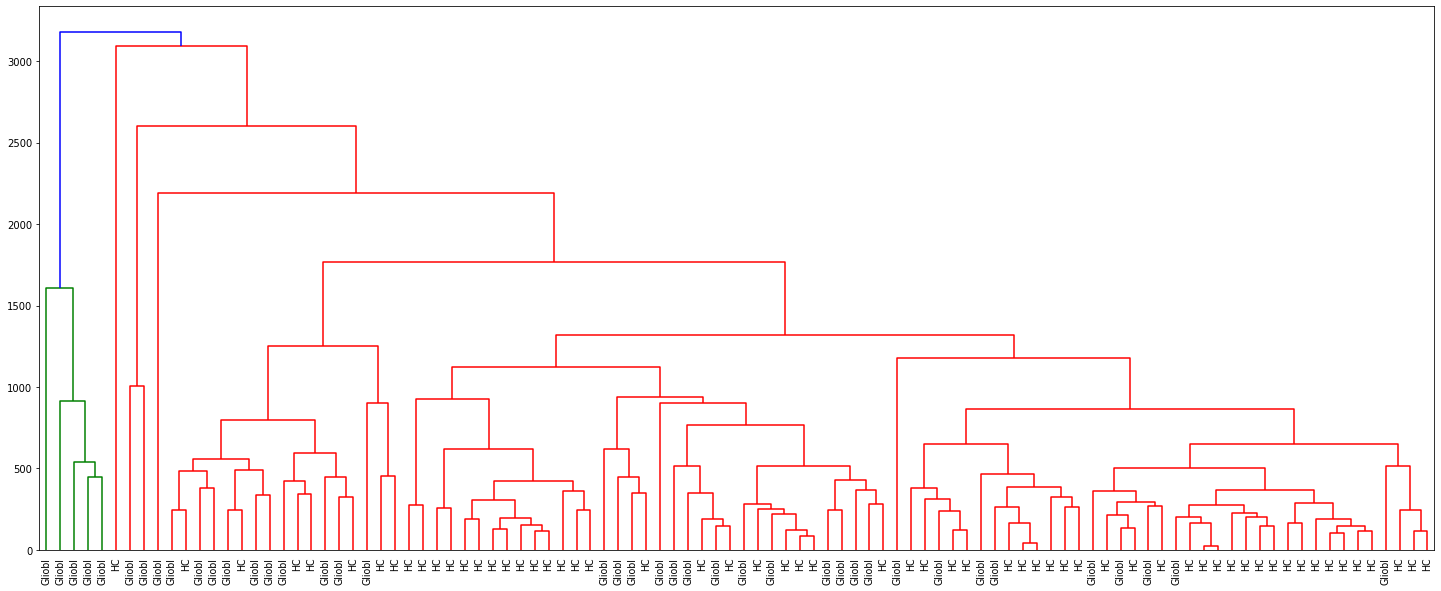

In [0]:
linked_average = linkage(GBM_RNAseq_geneRPKM_filt_data, 'average')
plt.figure(figsize=(25,10))
d = dendrogram(linked_average,
    orientation='top',
    labels=class_labels.tolist(),
    distance_sort='descending',
    leaf_font_size=9.5,
    color_threshold=3100)


Given that we'd like the healthy samples to constitute a different cluster from the GBM samples, we can investigate the extent to which our dendrogram with 2 classes splits up these two groups. To do this, we use a different implementation of the agglomerative clustering algorithm, this time from scikit-learn's "cluster" class.

In [0]:
cluster_average = cluster.AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='average')
cluster_assignments = pd.Series(cluster_average.fit_predict(GBM_RNAseq_geneRPKM_filt_data)).replace({0: 'HC', 1: 'Gliobl'})
print(f"""Cluster assignments:  
{list(cluster_assignments)}
""") 

Evaluate how well hierarchical clustering performs by calculating the fraction of correct assignments. Use the "sum" function to find the total number of correct assignments.

In [0]:
num_matched_assignments = sum(cluster_assignments == class_labels)
matched_assignments_average = num_matched_assignments / len(cluster_assignments)
print(f"""Fraction of matched class assignments using average linkage  =  {matched_assignments_average}

 
""")

It seems as if average linkage does not work so well (as we may have guessed just by visualizing the dendrogram). Thus, as an alternative, let's see if using complete linkage (discussed in lecture) improves things (an example of yet another alternative would be single linkage, though, in practice, single linkage tends to result in overly extended clusters, as a result of successive fusions resulting from very small numbers of samples. (Just for reference -- the fraction of matched class assignments for single linkage was found to be ~44%). As a first step, let's repeat the procedure from above: first run scipy's "linkage" algorithm:

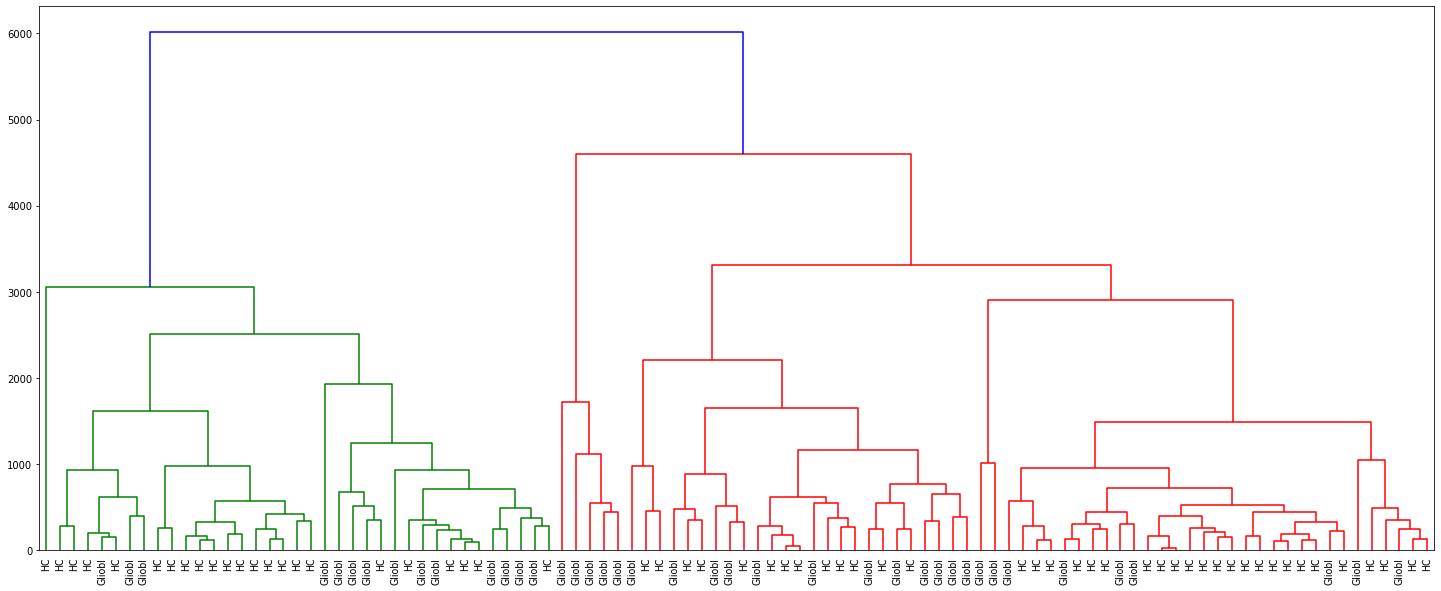

In [0]:
linked_complete = linkage(GBM_RNAseq_geneRPKM_filt_data, 'complete')
plt.figure(figsize=(25,10))
d = dendrogram(linked_complete,
    orientation='top',
    labels=class_labels.tolist(),
    distance_sort='descending',
    leaf_font_size=9.5,
    color_threshold=5000)

Now, run the second step: quantification of the fraction of correct assignment's using the scikit-learn package's "cluster.AgglomerativeClustering" algorithm.

In [0]:

cluster_complete = cluster.AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
cluster_assignments = pd.Series(cluster_complete.fit_predict(GBM_RNAseq_geneRPKM_filt_data)).replace({0: 'HC', 1: 'Gliobl'})
print(f"""Cluster assignments:  
{list(cluster_assignments)}

""")


# Evaluate how well hierarchical clustering performs by calculating the fraction of correct assignments
num_matched_assignments = sum(cluster_assignments == class_labels)
matched_assignments_complete = num_matched_assignments / len(cluster_assignments)
print(f"Fraction of matched class assignments using complete linkage  =  {matched_assignments_complete}")

Cluster assignments:  
['HC', 'Gliobl', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'Gliobl', 'HC', 'HC', 'Gliobl', 'Gliobl', 'HC', 'Gliobl', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'HC', 'Gliobl', 'Gliobl', 'Gliobl', 'Gliobl', 'Gliobl', 'Gliobl', 'Gliobl', 'Gliobl', 'HC', 'HC', 'HC', 'Gliobl', 'HC', 'HC', 'HC', 'HC', 'HC', 'Gliobl', 'HC', 'Gliobl', 'Gliobl', 'HC', 'Gliobl', 'Gliobl', 'HC', 'HC', 'HC', 'Gliobl', 'HC', 'Gliobl', 'Gliobl', 'HC', 'HC', 'HC', 'Gliobl', 'HC', 'HC', 'HC', 'Gliobl', 'Gliobl', 'HC', 'HC', 'HC', 'Gliobl', 'HC', 'HC', 'Gliobl', 'HC', 'HC', 'Gliobl', 'HC', 'HC', 'HC', 'Gliobl', 'Gliobl', 'Gliobl', 'HC', 'HC', 'HC', 'HC', 'Gliobl', 'HC', 'HC', 'HC', 'Gliobl', 'Gliobl', 'HC', 'HC', 'Gliobl', 'HC', 'HC', 'HC', 'Gliobl', 'HC', 'HC', 'Gliobl']


Fraction of matched class assignments using complete linkage  =  0.51


**Conclusion of clustering analysis:** What is clear from these analyses is that simple agglomerative clustering is not sufficient to define clear clusters. Accordingly, the simple criteria that go into these unsupervised methods were unable to discriminate between the cases and controls. Next, we move on to **Supervised** methods to see if we can come up with better models.

## Supervised Methods

In the following section, you will construct an outer loop over different possible training/testing dataset parcellations, i.e. you will separate out a different fraction of the total number of samples as your training set for each iteration of the loop.

In the body of the loop, you will first execute a logistic regression.

### Logistic Regression
Use the 'cross_val_score' function to perform 5 fold cross-validation, while training a logistic classifier with an l2 penalty term. The penalty term should be varied over the range 10, 1, 0.1 ... 1e-8.  Plot the cross validation scores across this range, then train a classifier using all the training data with the best regularizer, and evaluate the final training and test set accuracy.

training accuracy: 1.0
testing accuracy: 0.9302325581395349


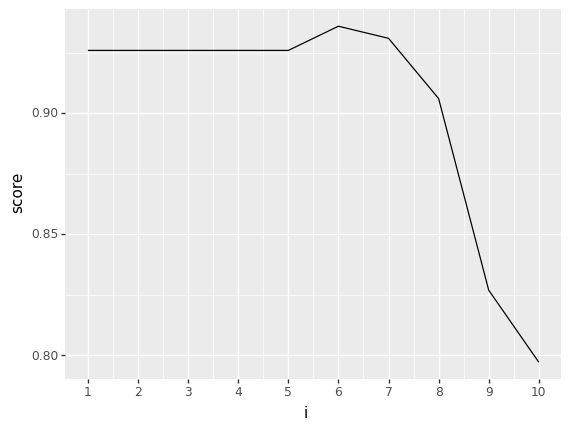

<ggplot: (8747236890965)>

In [0]:
train = pd.read_csv("/content/gdrive/My Drive/[YCMI_CBDS Summer Course] Data/bioinformatics/Pancancer_train.txt",sep="\t")
test = pd.read_csv("/content/gdrive/My Drive/[YCMI_CBDS Summer Course] Data/bioinformatics/Pancancer_test.txt",sep="\t")
####Separate out a training set and a test set (remove the column called
#### 'CancerStatus' from the training and test input dataframes)
X = train.drop('CancerStatus', axis=1)
y = train['CancerStatus']
X2 = test.drop('CancerStatus', axis=1)
y2 = test['CancerStatus']

#### Loop over all the possible values of the 'hyperparameter' C, and run the 
#### SVC and cross_val_score for each choice of C; store the mean values of the
#### cross-validation scores in the 'scores' list
scores = []
for i in range(10):
    clf = LogisticRegression(C=10**(1-i), penalty='l2', solver='liblinear')
    sc = cross_val_score(clf, X, y, cv=5)
    scores.append(sc.mean())
  
#Create pandas dataframe out of the scores list, using a dictionary construct
scores_df = pd.DataFrame({'i': range(1, len(scores) + 1), 'score': scores})

#Identify the index i_star corresponding to the maximum cross validation score above
i_star = scores_df['score'].idxmax()

#Run Logistic regression with i_star 
clf_lr = LogisticRegression(C=10**(1-i_star), penalty='l2', solver='liblinear')
clf_lr.fit(X, y)
train_acc = clf_lr.score(X, y)
test_acc = clf_lr.score(X2, y2)
print(f"training accuracy: {train_acc}")
print(f"testing accuracy: {test_acc}")

p9.ggplot(scores_df) + p9.geom_line(p9.aes(x="i",y="score"), group="1") + p9.scale_x_continuous(breaks=range(11))

### Support Vector Machines
Repeat the process above, but train a linear SVM classifier.  Use cross validation to set the penalty term 'C', letting it vary across the range 1000, 100, ... 1e-6.

training accuracy: 0.9752475247524752
testing accuracy: 0.9418604651162791


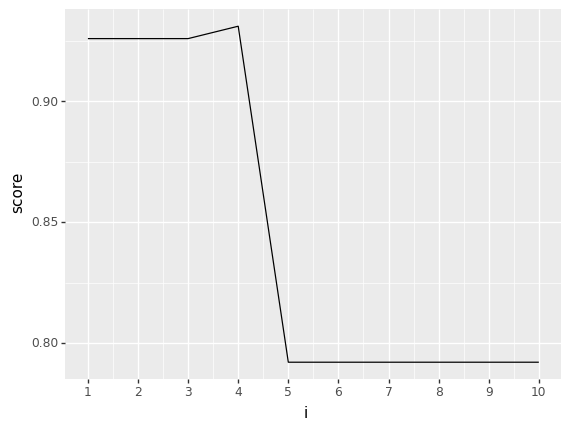

<ggplot: (8747236924031)>

In [0]:
train = pd.read_csv("/content/gdrive/My Drive/[YCMI_CBDS Summer Course] Data/bioinformatics/Pancancer_train.txt",sep="\t")
test = pd.read_csv("/content/gdrive/My Drive/[YCMI_CBDS Summer Course] Data/bioinformatics/Pancancer_test.txt",sep="\t")
####Separate out a training set and a test set (remove the column called
#### 'CancerStatus' from the training and test input dataframes)
X = train.drop('CancerStatus', axis=1)
y = train['CancerStatus']
X2 = test.drop('CancerStatus', axis=1)
y2 = test['CancerStatus']

#### Loop over all the possible values of the 'hyperparameter' C, and run the 
#### SVC and cross_val_score for each choice of C; store the mean values of the
#### cross-validation scores in the 'scores' list
scores = []
for i in range(10):
    clf = svm.SVC(kernel='linear', C=1000**(1-i))
    sc = cross_val_score(clf, X, y, cv=5)
    scores.append(sc.mean())
  
#Create pandas dataframe out of the scores list, using a dictionary construct
scores_df = pd.DataFrame({'i': range(1, len(scores) + 1), 'score': scores})

#Identify the index i_star corresponding to the maximum cross validation score above
i_star = scores_df['score'].idxmax()

#Run SVM with i_star 
clf_svm = svm.SVC(C=1000**(1-i_star), kernel='linear')
clf_svm.fit(X, y)
train_acc = clf_svm.score(X, y)
test_acc = clf_svm.score(X2, y2)
print(f"training accuracy: {train_acc}")
print(f"testing accuracy: {test_acc}")

p9.ggplot(scores_df) + p9.geom_line(p9.aes(x="i",y="score"), group="1") + p9.scale_x_continuous(breaks=range(11))

## Analysis of the quality of results

In this section, you will draw a so-called "Receiver-Operator Characteristic" Curve or ROC Curve. This curve provides a visual representation of the quality of your model: it consists of a plot of the true positive rate $(= \frac{Number\ of\ True\ Positive\ Calls\ by\ the\ Model}{Number\ of\ Actual\ Positives} )$ on the y-axis and the false positive rate $(= \frac{Number\ of\ False\ Positive\ Calls\ by\ the\ Model}{Number\ of\ Actual\ Negatives} )$ on the x-axis.

Use 'roc_curve' and 'auc' functions from sklearn.metrics to plot ROC curves for the logistic regression and SVM classifiers learnt above, and print out the AUC values for each classifier. 

In the first two lines, we provide the code for using 'decision functions': a decision function is the score you get from using your calculated model (LR or SVC) on your testing dataset, and is a measure of where a sample is relative to the decision boundary.


### ROC curve

LR AUC: 0.9763071895424837
SVM AUC: 0.994281045751634


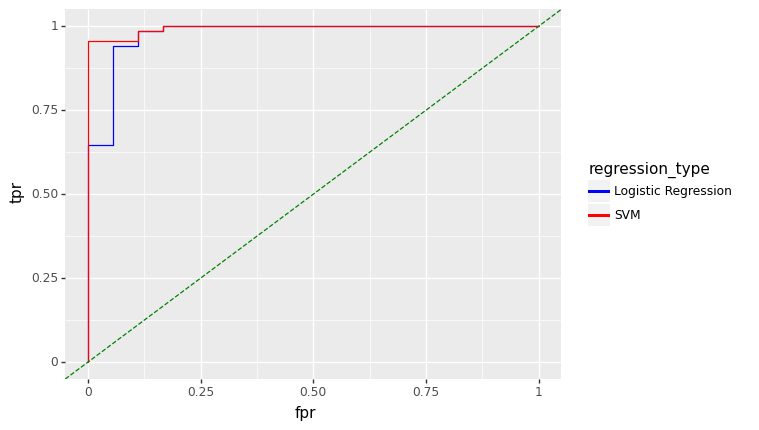

<ggplot: (-9223363289622166384)>

In [0]:
y_score_lr = clf_lr.decision_function(X2)
y_score_svm = clf_svm.decision_function(X2)
####Find roc_curve here
fpr1, tpr1, _ = roc_curve(y2, y_score_lr)
fpr2, tpr2, _ = roc_curve(y2, y_score_svm)

# TODO: not this. Just plot two different lines
roc_dict = {"regression_type":["Logistic Regression"]*len(fpr1) + ["SVM"]*len(fpr2),
            "fpr":list(fpr1) + list(fpr2),
            "tpr":list(tpr1) + list(tpr2)
}

roc_df = pd.DataFrame(roc_dict)

auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)
print(f"LR AUC: {auc1}")
print(f"SVM AUC: {auc2}")

(
    p9.ggplot(roc_df)
    + p9.geom_line(p9.aes(x="fpr",y="tpr",color="regression_type",group="regression_type"))
    + p9.scale_color_manual({"Logistic Regression":"blue","SVM":"red"})
    + p9.geom_abline(intercept=0,slope=1,linetype='dashed',color='green')
)


### Genes ranked according to weights in models 

Find the most discriminative genes, by ordering the coefficients of the logistic regression and SVM classifiers (use the coef_ attribute) by their absolute values.  Write out the 10 genes with the highest values, and their associated (signed) coefficients. 

In [0]:
geneIds = pd.read_csv("/content/gdrive/My Drive/[YCMI_CBDS Summer Course] Data/bioinformatics/GeneNames_Pancancer_filtered.txt",
                      header=None,
                      names=['gene'])


idx = pd.DataFrame.abs(clf_lr.coef_[0]).argsort()
idx = idx[::-1]

print(f"""Pancancer, LR, top geneIds:
{geneIds['gene'][idx[0:10]]}

Cofficients:
{clf_lr.coef_[0,idx[0:10]]}

""")

idx = pd.DataFrame.abs(clf_svm.coef_[0]).argsort()
idx = idx[::-1]

print(f"""Pancancer, SVM, top geneIds:
{geneIds['gene'][idx[0:10]]}

Coefficients:
{clf_svm.coef_[0,idx[0:10]]}""")

Pancancer, LR, top geneIds:
925        DEFA3
265      ARHGDIB
780    HIST1H2BC
122       FKBP1A
324        PRDX6
712        LIMS1
389        GNG11
400         SAT1
539      TMEM140
881      HLA-DRA
Name: gene, dtype: object

Cofficients:
[ 0.00802941  0.00786739  0.00657518 -0.00599873 -0.00535249 -0.00520535
 -0.00433601 -0.0042517   0.0040353  -0.00402329]


Pancancer, SVM, top geneIds:
925                DEFA3
362                F13A1
265              ARHGDIB
939    ENSG00000272053.1
389                GNG11
930               MALAT1
400                 SAT1
780            HIST1H2BC
881              HLA-DRA
164                TUBB1
Name: gene, dtype: object

Coefficients:
[ 0.00180754  0.0012803   0.00118351  0.00117131 -0.00115381 -0.00110009
 -0.00092042  0.00080441 -0.00068527 -0.00068008]


### **Further practice:** Repeat SVM training and evaluation with GBM data
Repeat all steps from the 'SVM classifier' section above to train and evaluate an SVM classifier using the GBM data, plot an ROC curve and find the most discriminative genes.

scores_df:     i     score
0   1  0.742857
1   2  0.742857
2   3  0.700000
3   4  0.742857
4   5  0.600000
5   6  0.600000
6   7  0.600000
7   8  0.600000
8   9  0.600000
9  10  0.600000
GBM training accuracy: 1.0
GBM testing accuracy: 0.8333333333333334

GBM, SVM, top geneIds:
4      FKBP5
45    TCEAL9
40     CLIC4
48     TRBC2
17      MFN2
29     SKAP1
22     ABCC4
15     IL1R2
18       MPL
3      IPO11
Name: gene, dtype: object

Coefficients:
[ 0.11176923  0.09953155 -0.08404336 -0.07456989  0.07307769 -0.07187333
  0.06245034  0.05988366  0.05897254  0.05451153]



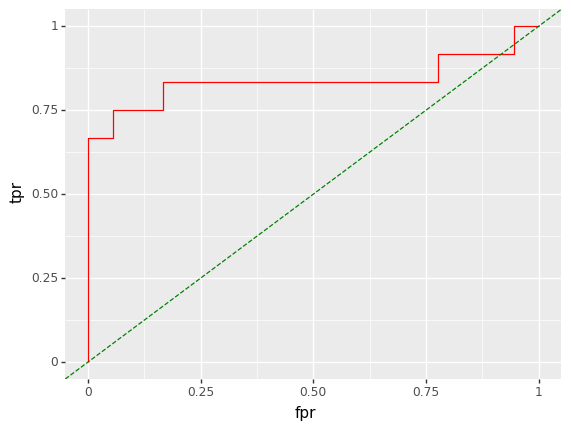

<ggplot: (8747232536240)>

In [0]:
train = pd.read_csv("/content/gdrive/My Drive/[YCMI_CBDS Summer Course] Data/bioinformatics/GBM_train.txt", sep="\t")
test = pd.read_csv("/content/gdrive/My Drive/[YCMI_CBDS Summer Course] Data/bioinformatics/GBM_test.txt", sep="\t")
####Separate out a training set and a test set (remove the column called
#### 'CancerStatus' from the training and test input dataframes)
X = train.drop("CancerStatus", axis=1)
y = train['CancerStatus']
X2 = test.drop("CancerStatus", axis=1)
y2 = test['CancerStatus']

#### Loop over all the possible values of the 'hyperparameter' C, and run the 
#### SVC and cross_val_score for each choice of C; store the mean values of the
#### cross-validation scores in the 'scores' list
scores = []
for i in range(10):
    clf = svm.SVC(kernel='linear', C=1000**(1-i))
    sc = cross_val_score(clf, X, y, cv=5)
    scores.append(sc.mean())
  
#Create pandas dataframe out of the scores list, using a dictionary construct
scores_df = pd.DataFrame({'i': range(1, len(scores) + 1), 'score': scores})

#Identify the index i_star corresponding to the maximum cross validation score above
# Check the score matrix and see if multiple values of C produce the same
#cross-validation score
i_star = scores_df['score'].idxmax()

#run SVM with i_star 
clf_svm = svm.SVC(C=1000**(1-i_star), kernel='linear')
clf_svm.fit(X, y)
train_acc = clf_svm.score(X, y)
test_acc = clf_svm.score(X2, y2)

y_score_svm = clf_svm.decision_function(X2)

idx = pd.DataFrame.abs(clf_svm.coef_[0]).argsort()
idx = idx[::-1]
geneIds = pd.read_csv("/content/gdrive/My Drive/[YCMI_CBDS Summer Course] Data/bioinformatics/GeneNames_GBM_filtered.txt",
                      header=None,
                      names=['gene'])


print(f"""GBM training accuracy: {train_acc}
GBM testing accuracy: {test_acc}

GBM, SVM, top geneIds:
{geneIds['gene'][idx[:10]]}

Coefficients:
{clf_svm.coef_[0,idx[0:10]]}
""")

fpr, tpr, _ = roc_curve(y2, y_score_svm)

(
    p9.ggplot(pd.DataFrame({"tpr":tpr,"fpr":fpr}))
    + p9.geom_line(p9.aes(x="fpr",y="tpr"), color='red',linetype='solid')
    + p9.geom_abline(intercept=0,slope=1,linetype='dashed',color='green')
)
